In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

In [2]:
df = pd.read_csv('test_pairs.csv')
print(df.shape)
df.head()

(368550, 3)


,pairId,FirstId,SecondId
0,0,1427,8053
1,1,17044,7681
2,2,19237,20966
3,3,8005,20765
4,4,16837,599


In [3]:
pairs = df[['FirstId', 'SecondId']].drop_duplicates()
pairs.shape

(368538, 2)

In [4]:
k1 = df['FirstId'].value_counts().value_counts()
k1

15    1755
14    1755
13    1755
12    1755
11    1755
10    1755
9     1755
8     1755
7     1755
21    1755
20    1755
19    1755
18    1755
17    1755
16    1755
Name: FirstId, dtype: int64

In [5]:
k2 = df['SecondId'].value_counts().value_counts()
k2

14    1755
13    1755
12    1755
11    1755
10    1755
9     1755
8     1754
15    1740
17    1740
18    1740
19    1740
16    1740
20    1739
21    1695
7     1605
22     150
6       60
5       16
4       15
3       15
2       15
1       15
23       1
Name: SecondId, dtype: int64

In [6]:
diff = df['FirstId']-df['SecondId']
bins = diff.value_counts().unique().shape[0]
bins

397

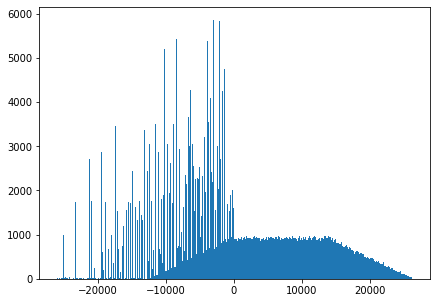

In [8]:
plt.figure(figsize=(7,5))
#save important characteristics
arr, bins, _ = plt.hist(diff, bins=bins)

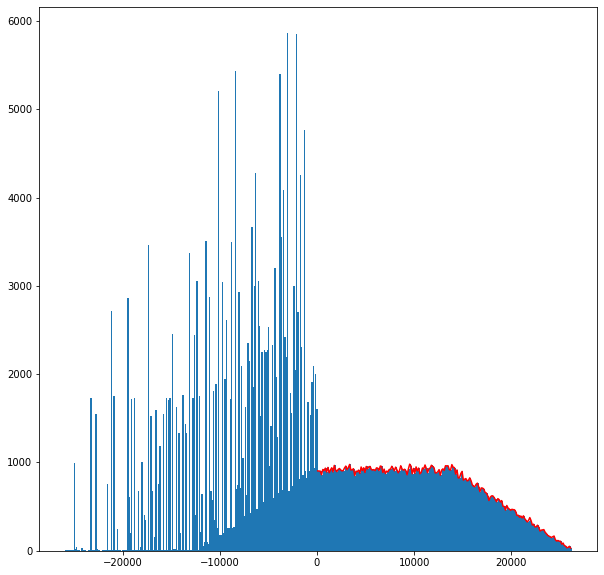

In [196]:
plt.figure(figsize=(10,10))
plt.hist(diff, bins=397)
#plot contour of part of trapeze
ixs_right = np.where(bins>=0)[0][:-1]
plt.plot(bins[ixs_right], arr[ixs_right], color='r')
plt.show()

**find line of left trapeze's side**

need to get two points by some emperical thoughts

In [180]:
ixs2 = np.where((bins>=-10100) & (bins<=-9900))[0]

In [181]:
print(f'bins {bins[ixs2]}', f'arr: {arr[ixs2]}')

bins [-10052.26196474  -9920.76826196] arr: [174. 177.]


In [182]:
ixs3 = np.where((bins>=-500) & (bins<=500))[0]

In [183]:
bins[ixs3]

array([-453.22166247, -321.7279597 , -190.23425693,  -58.74055416,
         72.75314861,  204.24685139,  335.74055416,  467.23425693])

In [184]:
arr[ixs3]

array([2098.,  943., 2002., 1611.,  905.,  904.,  902.,  862.])

In [185]:
#list of tuple (x, y) points
points = []
points.append((bins[ixs2[0]], arr[ixs2[0]]))
points.append((bins[ixs3[4]], arr[ixs3[4]]))

In [186]:
def line_by_two_points(x, points):
    '''Find equation of line using two points
    Retrun y of equation in point x
    '''
    x0, y0, x1, y1 = points[0][0], points[0][1], points[1][0], points[1][1]
    return (x * (y1 - y0) - x0*y1 + x1*y0) / (x1 - x0)

In [187]:
x_values = np.linspace(min(diff), max(diff), diff.shape[0])
y_values = [line_by_two_points(x, points) for x in x_values]

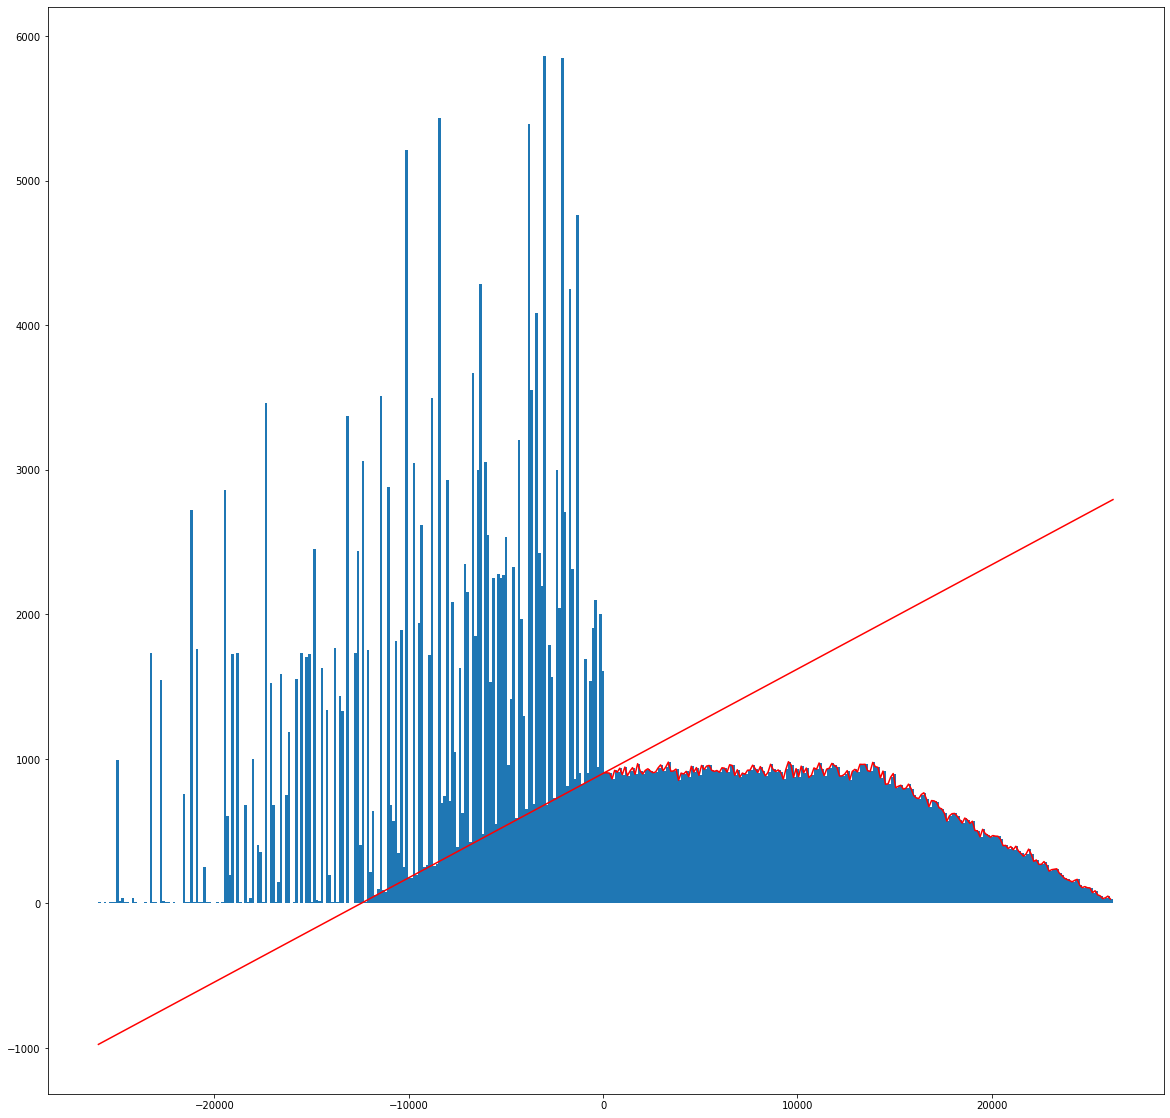

In [188]:
plt.figure(figsize=(20,20))
plt.hist(df['FirstId']-df['SecondId'], bins=397)
ixs=np.where(bins>=0)[0][:-1]
plt.plot(x_values, y_values, color='r')
plt.plot(bins[ixs], arr[ixs], color='r')
plt.show()

In [189]:
#find elements in given bins
val_binix = pd.DataFrame(list(zip(diff, np.digitize(diff, bins))), columns=['diff', 'bin'])
val_binix.head()

,diff,bin
0,-6626,148
1,9363,269
2,-1729,185
3,-12760,101
4,16238,321


We know the equation of the red line so we can compare if value in 'arr' is bigger than value calculated by the equation at the same point 'x' (x stores in bins remember)

In [190]:
#compare line and histogram
d = {}
for i, x in enumerate(bins):
    if i == len(bins)-1:
        break
    true_val = arr[i]
    line_val = line_by_two_points(x, points)
    d[i] = (x, true_val > line_val)

In [191]:
true_bins = [k for k, v in d.items() if v[1]]

In [192]:
val_binix['prediction'] = np.where(val_binix['bin'].isin(true_bins), 1, 0)

In [193]:
val_binix.head()

,diff,bin,prediction
0,-6626,148,1
1,9363,269,0
2,-1729,185,1
3,-12760,101,1
4,16238,321,0


In [194]:
submission = df.loc[:,['pairId']]
submission['Prediction'] = val_binix['prediction']

submission.to_csv('submission.csv', index=False)

In [195]:
submission.groupby(['Prediction']).count()

,pairId
Prediction,
0,163486
1,205064


Accuracy is 0.834652

Maybe number of bins should be different to get better score or only peaks above some threshold should be chosen to treat their values as class 1. Anyway it seems to be leakages